# Tutorial 18: Linear and nonlinear disambiguation optimization (LANDO)

In this tutorial, we demonstrate how one might use the `LANDO` module of PyDMD in order to model data that is too nonlinear and high-dimensional to be modeled by DMD. In particular, we examine the chaotic Lorenz system and coupled Kuramoto Oscillators to show that the LANDO algorithm can be a very effective tool for modeling highly nonlinear systems in a scalable manner.

## A brief overview of LANDO, the kernelized generalization of DMD

Created by Baddoo et al. in 2022 as a method that leverages the linear diagnostics of DMD, the scalability of kernel methods, and the nonlinear modeling capabilities of SINDy [2], the LANDO algorithm [1] is generally outlined as the following:

Given data matrices $\mathbf{X}, \mathbf{Y} \in \mathbb{R}^{n \times m}$, LANDO assumes that the snapshot pair $\mathbf{x}, \mathbf{y} \in \mathbb{R}^{n}$ is governed by some function $F$ such that

$$
\mathbf{y} = F(\mathbf{x}).
$$

We denote our approximation of the function $F$ as $f$, and assume that each term of $f(\mathbf{x})$ may be expressed as the weighted sum of $N$ candidate features $\varphi(\mathbf{x}) \in \mathbb{R}^N$ for some weight matrix $\mathbf{\Xi} \in \mathbb{R}^{n \times N}$. Note that solving for the matrix $\mathbf{\Xi}$ subject to regularization is equivalent to the SINDy optimization [2]. However, due to the oftentimes intractable size of the feature mapping $\varphi$, LANDO instead expresses this explicit feature mapping as an equivalent implicit kernel expression given by the appropriately-chosen kernel function $k$ and the weight matrix $\mathbf{W} \in \mathbb{R}^{n \times m}$.

$$
f(\mathbf{x}) = \mathbf{\Xi} \varphi(\mathbf{x}) = \mathbf{W}k(\mathbf{X}, \mathbf{x})
$$

Although we could simply solve for the weight matrix $\mathbf{W}$, this problem still has potential to be computationally expensive, especially when the number of samples $m$ is large. Hence instead, LANDO computes a feature dictionary $\tilde{\mathbf{X}} \in \mathbb{R}^{n \times \tilde{m}}$ that contains a small subset of snapshots from the matrix $\mathbf{X}$ such that the column space of $\tilde{\mathbf{X}}$ is as large as possible. The implicit kernel expression can then be approximated as follows, leading to the much more computationally-feasible task of computing $\tilde{\mathbf{W}} \in \mathbb{R}^{n \times \tilde{m}}$ rather than $\mathbf{W} \in \mathbb{R}^{n \times m}$. We refer readers to [1] for more details on how $\tilde{\mathbf{X}}$ is computed.

$$
f(\mathbf{x}) \approx \tilde{\mathbf{W}} k(\tilde{\mathbf{X}}, \mathbf{x}) \approx \mathbf{y}
$$

Once $\tilde{\mathbf{W}}$ is computed, typically via the pseudoinverse $\tilde{\mathbf{W}} = \mathbf{Y} k(\tilde{\mathbf{X}},\mathbf{X})^\dagger$, we obtain the model above, which may generally be used for prediction. Not only that, but given some base state $\bar{\mathbf{x}} \in \mathbb{R}^n$, we can express our system about this base state as follows for a constant bias term $\mathbf{c}$, a linear transformation $\mathbf{L}$, and an nonlinear operator $\mathbf{N}$ as long as the gradient of the kernel function $k$ is known. Note that $\mathbf{x}' = \mathbf{x} - \bar{\mathbf{x}}$ describes small perturbations about the base state. From this expression, we can obtain DMD diagnostics on the linear operator $\mathbf{L}$, along with nonlinear forcings from the operator $\mathbf{N}$.

$$
f(\mathbf{x}) = \mathbf{c} + \mathbf{L} \mathbf{x}' + \mathbf{N}(\mathbf{x}')
$$

In this tutorial, we discuss how the `LANDO` module of PyDMD can be used to compute and access all of these crucial pieces of the LANDO algorithm.

We begin with the following imports. We import `time` for runtime comparisons, `numpy` for basic computations, `matplotlib.pyplot` for plotting, and `scipy.integrate.solve_ivp` (along with some `solve_ivp` settings) for data generation. We additionally import the `DMD`, `EDMD`, and `LANDO` modules from the PyDMD package for our demonstrations. We then provide code for computing relative error, as well as code for computing second-order finite difference, as we will later be investigating models built using time derivative data.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from pydmd import DMD
from pydmd import EDMD
from pydmd import LANDO

# Settings to replicate odeint defaults.
solve_ivp_opts = {}
solve_ivp_opts["rtol"] = 1e-12
solve_ivp_opts["atol"] = 1e-12
solve_ivp_opts["method"] = "LSODA"


def relative_error(est, true):
    """
    Helper method for computing relative error.
    """
    return np.linalg.norm(true - est) / np.linalg.norm(true)


def differentiate(X, dt):
    """
    Method for performing 2nd order finite difference. Assumes the input
    matrix X is 2-D, with uniformly-sampled snapshots filling each column.
    Requires dt, which is the time step between each snapshot.
    """
    if not isinstance(X, np.ndarray) or X.ndim != 2:
        raise ValueError("Please ensure that input data is a 2D array.")
    X_prime = np.empty(X.shape)
    X_prime[:, 1:-1] = (X[:, 2:] - X[:, :-2]) / (2 * dt)
    X_prime[:, 0] = (-3 * X[:, 0] + 4 * X[:, 1] - X[:, 2]) / (2 * dt)
    X_prime[:, -1] = (3 * X[:, -1] - 4 * X[:, -2] + X[:, -3]) / (2 * dt)

    return X_prime

## Example 1: Chaotic Lorenz System

In order to demonstrate the utility of the LANDO algorithm, we first examine the Lorenz system, whose governing equations are given by the following system of ODEs. We examine this system for the chaotic parameter values $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

$$
\begin{cases}
\dot{x} = \sigma (y-x) \\
\dot{y} = x(\rho-z)-y \\ 
\dot{z} = xy - \beta z
\end{cases}
$$

Provided below is code that uses `scipy.integrate.solve_ivp` to propagate this system forward in time from an initial condition, which we set to be $(x_0, y_0, z_0) = (-8,8,27)$ by default. We then generate Lorenz system data from time $t=0$ to time $t=10$ for the uniform time step $\Delta t = 10^{-3}$ to remain consistent with the experiments of the LANDO paper [1]. We also use $\mathbf{x}_j = [x(j\Delta t) \: y(j\Delta t) \: z(j\Delta t)]^\top$ and $\mathbf{y}_j = \dot{\mathbf{x}}_j$ as our input data.

In [2]:
# Chaotic Lorenz parameters:
sigma, rho, beta = 10, 28, 8 / 3


def generate_lorenz_data(t_eval, x0=(-8, 8, 27)):
    """
    Given a time vector t_eval = t1, t2, ..., evaluates and
    returns the snapshots of the Lorenz system as columns of
    the matrix X for the initial condition x0.
    """

    def lorenz_system(t, state):
        x, y, z = state
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return [x_dot, y_dot, z_dot]

    sol = solve_ivp(
        lorenz_system,
        [t_eval[0], t_eval[-1]],
        x0,
        t_eval=t_eval,
        **solve_ivp_opts,
    )

    return sol.y


def plot_lorenz_reconstruction(true_data, recon_data, recon_title, recon_color):
    """
    Helper function that plots the provided true Lorenz trajectory side-by-side
    with the provided reconstructed trajectory. Uses the provided plotting
    parameters for the reconstruction subplot.
    """
    fig = plt.figure(figsize=(6, 3))
    # Plot the true trajectory in black.
    ax = fig.add_subplot(121, projection="3d")
    ax.plot(true_data[0], true_data[1], true_data[2], c="k")
    ax.set_title("True system")
    ax.set_xlim([-29, 29])
    ax.set_ylim([-29, 29])
    ax.set_zlim([5, 45])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # Plot the reconstructed trajectory in the given color.
    ax = fig.add_subplot(122, projection="3d")
    ax.plot(recon_data[0], recon_data[1], recon_data[2], c=recon_color)
    ax.set_title(recon_title)
    ax.set_xlim([-29, 29])
    ax.set_ylim([-29, 29])
    ax.set_zlim([5, 45])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.tight_layout()
    plt.show()


def plot_fixed_point_results(c, L, N):
    """
    Helper function that plots the provided bias term, linear operator,
    and nonlinear operator. Visualizes fixed point analysis results.
    """
    plt.figure(figsize=(9, 2))
    plt.subplot(1, 3, 1)
    plt.title("Bias")
    plt.imshow(c, cmap="bwr", vmax=12, vmin=-12)
    plt.colorbar()
    plt.xticks([])
    plt.subplot(1, 3, 2)
    plt.title("Linear Operator")
    plt.imshow(L, cmap="bwr", vmax=12, vmin=-12)
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title("Nonlinear Forcing")
    plt.imshow(N, aspect="auto", vmax=490, vmin=-490)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# Generate Lorenz system data.
dt = 0.001
t = np.arange(0, 10, dt)
X = generate_lorenz_data(t)
Y = differentiate(X, dt)

## DMD cannot capture the nonlinearities of the system

We begin by pointing out that the highly nonlinear nature of the chaotic Lorenz system simply cannot be captured by a simple linear model. One way of observing this is by attempting to fit a regular DMD model to the Lorenz system data, as DMD models are simple linear operators by construction.

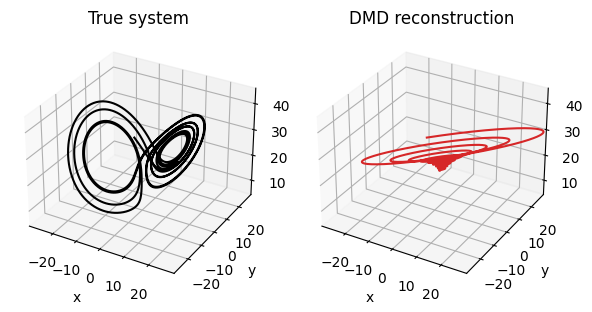

In [3]:
dmd = DMD(svd_rank=3).fit(X)
dmd_recon = dmd.reconstructed_data.real
plot_lorenz_reconstruction(X, dmd_recon, "DMD reconstruction", "tab:red")

## EDMD captures nonlinearities, but sometimes faces closure and scalability issues

Not to be confused with LANDO, the Extended DMD (EDMD) algorithm [3,4] implemented in the `EDMD` module assumes a model of the form

$$
\varphi(\mathbf{y}) = \mathbf{K} \varphi(\mathbf{x})
$$

for the nonlinear feature mapping $\varphi$ and the linear operator $\mathbf{K}$. Like LANDO, this method has also been kernelized for greater computational efficiency [4]. However, since kernelized EDMD does not utilize sparse dictionary learning, data sets with a large number of snapshots $m$ still pose computational hurdles. In addition, it has been shown that EDMD sometimes suffers from closure issues, especially when one's system contains multiple fixed points or periodic orbits [5]. We demonstrate these shortcomings below, as we find that the `EDMD` module struggles to reconstruct the Lorenz system in a fair amount of time, even after using an appropriate `svd_rank` cutoff and a polynomial kernel of sufficiently high degree.

EDMD Fitting Time: 731.1543672084808


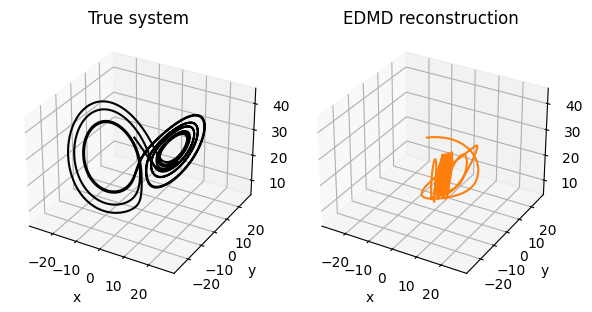

In [4]:
t1 = time.time()
edmd = EDMD(
    svd_rank=18,
    kernel_metric="poly",
    kernel_params={"degree": 3, "coef0": 1.0, "gamma": 1.0},
)
edmd.fit(X)
t2 = time.time()
print("EDMD Fitting Time: {}".format(t2 - t1))

edmd_recon = edmd.reconstructed_data.real
plot_lorenz_reconstruction(X, edmd_recon, "EDMD reconstruction", "tab:orange")

## LANDO captures nonlinearities, scales effectively, and allows for on-the-fly updates

We now demonstrate that LANDO is able to overcome the previous issues and produce a highly-accurate and predictive model. First, we note that unlike most other PyDMD modules, the `LANDO` module of the PyDMD package is fit via two separate fitting routines:

**FITTING STEP 1: `fit()`** 

First, the weights of the dictionary-based kernel model $\tilde{\mathbf{W}}$ must be computed given the input data $\mathbf{X}, \mathbf{Y}$. This is done via a call to `fit()`.

**FITTING STEP 2: `analyze_fixed_point()`**

Once $\tilde{\mathbf{W}}$ has been computed, the model $f(\mathbf{x}) = \mathbf{c} + \mathbf{L} \mathbf{x}' + \mathbf{N}(\mathbf{x}')$ at a fixed point $\bar{\mathbf{x}}$ may be computed via a call to `analyze_fixed_point()`.

We demonstrate this fitting routine below, using the fixed point

$$
\bar{\mathbf{x}} = [-\sqrt{\beta (\rho - 1)} \quad -\sqrt{\beta (\rho - 1)} \quad \rho - 1]^\top
$$

of the Lorenz system. Below, we make use of the following notable `LANDO` parameters, which we explain here:

- The `svd_rank` parameter controls the rank truncation used when computing the diagnostics of the linear operator at a fixed point.

- The `kernel_metric` string used in conjunction with the `kernel_params` dictionary is one way users can define their desired kernel functions and function parameters. These inputs work with the `sklearn.metrics.pairwise.pairwise_kernels` function behind the scenes in order to compute kernel matrices. Since the LANDO pipeline requires the computation of both kernel matrices and kernel gradients, the `LANDO` module is currently only compatible with the `"linear"`, `"poly"`, and `"rbf"` metrics.

- The `x_rescale` parameter defines a re-scaling factor for the input data $\mathbf{X}$, and is generally used to improve data conditioning. This parameter can either be a single value, or it can be a numpy array of values with the same dimension as a single input snapshot.

- The `dict_tol` parameter specifies the tolerance used when adding snapshots to the dictionary $\tilde{\mathbf{X}}$. In short, increasing this tolerance will lead to smaller dictionaries, while decreasing it will lead to larger dictionaries.

In [5]:
# Lorenz system fixed point.
x_bar = [
    -np.sqrt(beta * (rho - 1)),
    -np.sqrt(beta * (rho - 1)),
    rho - 1,
]

t1 = time.time()

# Build the LANDO model.
lando = LANDO(
    svd_rank=3,
    kernel_metric="poly",
    kernel_params={"degree": 3, "coef0": 1.0, "gamma": 1.0},
    x_rescale=1 / np.abs(X).max(axis=1),
    dict_tol=1e-6,
)

# FITTING PART 1: Fit the model to the input data.
# This step computes the weights of the dictionary-based kernel model.
lando.fit(X, Y)

# FITTING PART 2: Obtain diagnostics about a fixed point.
# This step computes the linear model diagnostics and nonlinear forcings.
# Use compute_A=True to explicitly compute and store the linear operator.
lando.analyze_fixed_point(x_bar, compute_A=True)

t2 = time.time()

print("LANDO Fitting Time: {}".format(t2 - t1))

LANDO Fitting Time: 4.175309658050537


Once `fit()` has been called, users may access the terms from the expression

$$
f(\mathbf{x}) \approx \tilde{\mathbf{W}} k(\tilde{\mathbf{X}}, \mathbf{x}) \approx \mathbf{y}.
$$

The sparse dictionary $\tilde{\mathbf{X}}$ may be viewed via the `sparse_dictionary` property of the `LANDO` model, while the weights $\tilde{\mathbf{W}}$ are stored in the `weights` property of the `LANDO` operator. Users also gain access to the function `f()`, which yields predictions of the true system model $F(\cdot)$. The `predict()` function also becomes available, which uses the computed LANDO model to propagate the system forward in time from an initial condition of choice. Hence, `predict()` may be used to not only compute system reconstructions, but also make future-state predictions and advance the system from a new initial condition.

LANDO Training Error:       0.00038%
LANDO Dictionary Size:      20
Original Number of Samples: 10000


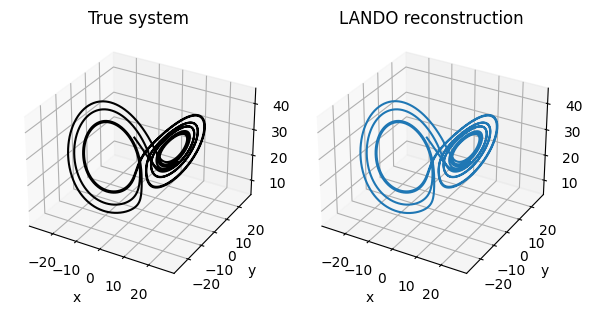

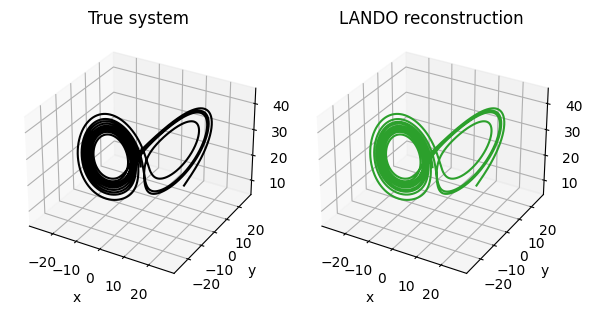

In [6]:
# View the size of the sparse dictionary, and the training accuracy of the predicted model.
dictionary_size = lando.sparse_dictionary.shape[-1]
Y_est = lando.f(X)
lando_error = np.round(relative_error(Y_est, Y), decimals=7) * 100

print("LANDO Training Error:       {}%".format(lando_error))
print("LANDO Dictionary Size:      {}".format(dictionary_size))
print("Original Number of Samples: {}".format(len(t)))

# Reconstruct the system using the learned model via the predict function.
lando_recon = lando.predict(
    x0=(-8, 8, 27),
    tend=len(t),
    continuous=True,
    dt=dt,
    solve_ivp_opts=solve_ivp_opts,
)
plot_lorenz_reconstruction(X, lando_recon, "LANDO reconstruction", "tab:blue")

# LANDO models can also be used to propagate the system forward from a new initial condition.
X_init2 = generate_lorenz_data(t, x0=(10, 14, 10))
lando_init2 = lando.predict(
    x0=(10, 14, 10),
    tend=len(t),
    continuous=True,
    dt=dt,
    solve_ivp_opts=solve_ivp_opts,
)
plot_lorenz_reconstruction(
    X_init2, lando_init2, "LANDO reconstruction", "tab:green"
)

Once `analyze_fixed_point()` has been called, users gain access to all of the terms from the model

$$
f(\mathbf{x}) = \mathbf{c} + \mathbf{L} \mathbf{x}' + \mathbf{N}(\mathbf{x}').
$$

This includes the bias term $\mathbf{c}$, the linear operator $\mathbf{L}$ (if requested to be computed explicitly via `compute_A=True`), and the nonlinear operator $N(\cdot)$, which may be accessed via `bias`, `linear`, and `nonlinear()` respectively. Users also gain access to standard DMD properties such as `eigs`, `modes`, and `amplitudes`, whether or not `compute_A=True`, as these properties are tied to the linear operator $\mathbf{L}$. Here, we plot the bias term, the linear operator, and the nonlinear forcing, and show that the computed linear operator does indeed match the expected linearization about our fixed point.

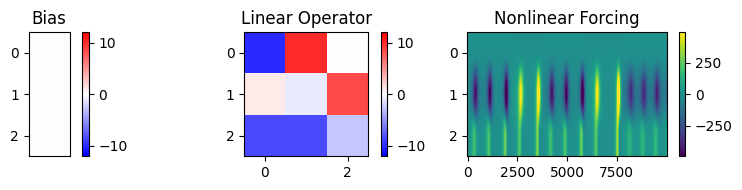

True A:
[[-10.     10.      0.   ]
 [  1.     -1.      8.485]
 [ -8.485  -8.485  -2.667]]

LANDO A:
[[-10.     10.     -0.   ]
 [  1.     -1.      8.485]
 [ -8.486  -8.484  -2.667]]


In [7]:
c = lando.bias
L = lando.linear
N = lando.nonlinear(X)

# Plot c, L, and N(x).
plot_fixed_point_results(c, L, N)

# True linear operator about our fixed point.
A_true = np.array(
    [
        [-sigma, sigma, 0.0],
        [1.0, -1.0, np.sqrt(beta * (rho - 1))],
        [-np.sqrt(beta * (rho - 1)), -np.sqrt(beta * (rho - 1)), -beta],
    ]
)
print("True A:")
print(np.round(A_true, decimals=3))
print("\nLANDO A:")
print(np.round(lando.linear, decimals=3))

What's more is that **LANDO models can be updated on-the-fly** thanks to their compatibility with online learning updates. In other words, fitted LANDO models can be updated if they are given more snapshot data! To enable this feature, set `online=True` when initializing a `LANDO` model. Then once `fit()` has been called, users may take adavantage of the `update()` method, which accepts additional snapshot data and updates the model accordingly.

We demonstrate this process below, as we fit a `LANDO` model with online learning enabled, first with $T = 500$ samples of our Lorenz data, and then later with more and more data. Notice that our model's ability to correctly reconstruct the Lorenz system improves as it is given more data. Also notice that the results of the fixed point analysis are also updated, assuming one has been performed prior to the update.

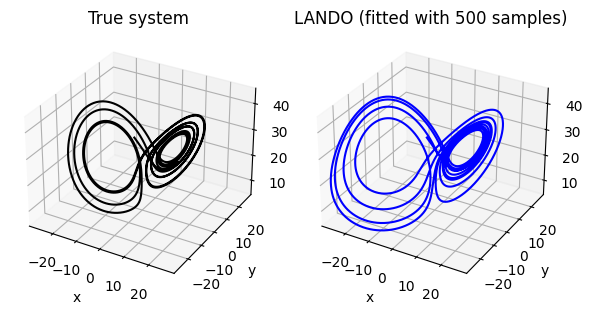

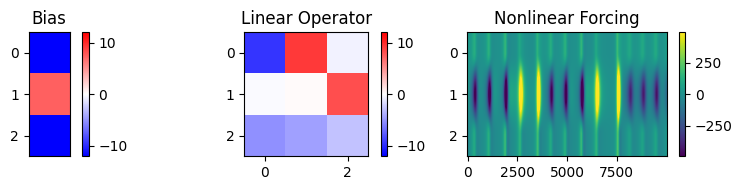

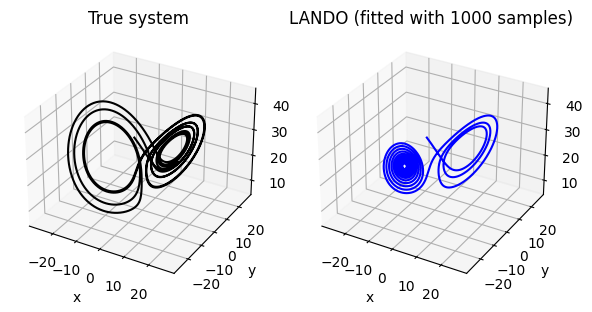

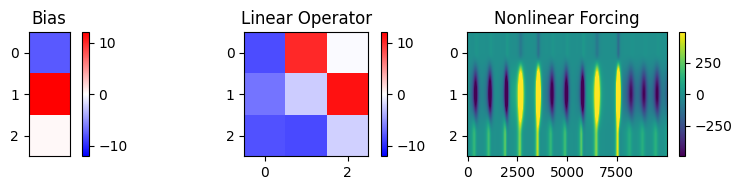

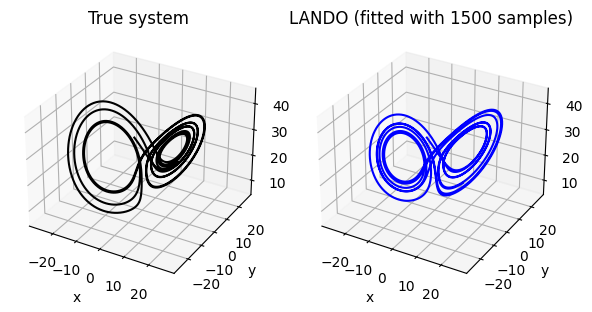

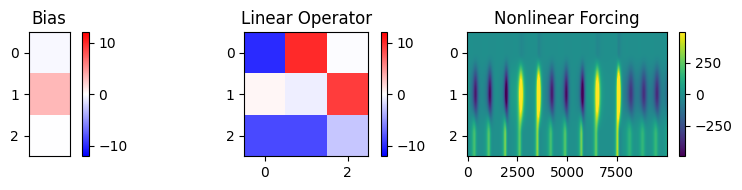

In [8]:
# Define the size of the data batches and the initial batch.
T = 500
X_init = X[:, :T]
Y_init = Y[:, :T]

# Initialize a LANDO model with online learning enabled.
lando_online = LANDO(
    svd_rank=3,
    kernel_metric="poly",
    kernel_params={"degree": 3, "coef0": 1.0, "gamma": 1.0},
    x_rescale=1 / np.abs(X_init).max(axis=1),
    dict_tol=1e-5,
    online=True,
)
lando_online.fit(X_init, Y_init)
lando_online.analyze_fixed_point(x_bar, compute_A=True)

# Update the model, each time feeding in a new batch of data.
for i in [1, 2, 3]:
    # Plot the model's current ability to reconstruct all 10000 original data points.
    title = "LANDO (fitted with {} samples)".format(i * T)
    lando_recon = lando_online.predict(
        x0=(-8, 8, 27),
        tend=len(t),
        continuous=True,
        dt=dt,
        solve_ivp_opts=solve_ivp_opts,
    )
    plot_lorenz_reconstruction(X, lando_recon, title, "b")

    # Plot the model's fixed point analysis results.
    c = lando_online.bias
    L = lando_online.linear
    N = lando_online.nonlinear(X)
    plot_fixed_point_results(c, L, N)

    # Update the model using T more data snapshots.
    X_new = X[:, (i * T) : ((i + 1) * T)]
    Y_new = Y[:, (i * T) : ((i + 1) * T)]
    lando_online.update(X_new, Y_new)

## Example 2: Coupled Kuramoto Oscillators

In order to demonstrate a few more features of the `LANDO` module, we examine the Kuramoto model given by

$$
\dot{v}_i = \omega_i + \frac{1}{n} \sum_{j=1}^n a_{ij} \sin(v_j-v_i) + h\sin(v_j), \quad i = 1, 2, \dots, n.
$$

It was shown in the original LANDO paper [1] that LANDO is capable of extracting the true frequencies $\omega_i$ for a particular instance of this system. Here, we replicate those results using the $n=2000$ oscillator system examined in the LANDO paper. In particular, we examine the Kuramoto data set available with the [original LANDO code](https://github.com/baddoo/LANDO). Please refer to the LANDO paper [1] for more details on this particular system.

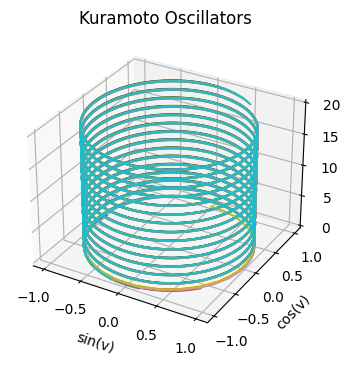

In [9]:
import warnings
import scipy.io as sio
from sklearn.metrics.pairwise import pairwise_kernels

# Import the Kuramoto data and declare parameters.
data = sio.loadmat("kuramotoData.mat")
freq_true = data["omegaTrue"]
X = data["X"]
Y = data["Y"]
n = X.shape[0]
t = np.linspace(0, 20, X.shape[1])

# Plot some of the oscillators.
fig = plt.figure(figsize=(4, 10))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("Kuramoto Oscillators")
for i in range(0, n, 200):
    ax.plot(np.sin(X[i]), np.cos(X[i]), t)
ax.set_xlabel("sin(v)")
ax.set_ylabel("cos(v)")
ax.set_zlabel("t", rotation=0)
plt.show()

In order to extract the true frequencies of the oscillators, Baddoo et al. applied LANDO equipped with the following kernel [1]. 

$$
k(\mathbf{u}, \mathbf{v}) = 
\Bigg(c + \gamma \begin{bmatrix} \sin(\mathbf{u}) \\ \cos(\mathbf{u}) \end{bmatrix}^\top
\begin{bmatrix} \sin(\mathbf{v}) \\ \cos(\mathbf{v}) \end{bmatrix} \Bigg)^d
$$

Users can define and pass custom kernel functions to the `LANDO` module via the `kernel_function` parameter. If provided, this function is used instead of the kernel function defined by the `kernel_metric` and `kernel_params` inputs. Note that the `kernel_function` function must return the kernel matrix $k(\mathbf{X}, \mathbf{Y}) \in \mathbb{R}^{m_x \times m_y}$ given the data matrices $\mathbf{X} \in \mathbb{R}^{n \times m_x}$, $\mathbf{Y} \in \mathbb{R}^{n \times m_y}$. Note that if a custom kernel function is provided, users must additionally provide the corresponding kernel gradient $\nabla k(\mathbf{X},\mathbf{y})$ via the `kernel_gradient` parameter *if* they wish to call `analyze_fixed_point()`. Since we only call `fit()` here, we do not provide this function. See the `LANDO` documentation for more information.

Notice that by using our custom kernel function, we obtain an accurate LANDO model that prodces good estimations of the true frequencies.

Frequency Error:            1.7209999999999999%
LANDO Training Error:       0.0018%
LANDO Dictionary Size:      220
Original Number of Samples: 1000


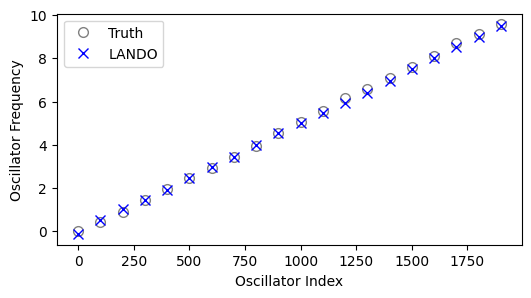

In [10]:
# Define the Kuramoto Oscillator kernel function.
custom_kernel = lambda X, Y: (
    pairwise_kernels(
        np.vstack([np.sin(X), np.cos(X)]).T,
        np.vstack([np.sin(Y), np.cos(Y)]).T,
        metric="poly",
        degree=2,
        coef0=1.0,
        gamma=0.1,
    )
)
# LANDO will warn us that we can't call analyze_fixed_point().
# Turn off warnings for the sake of this demonstration.
warnings.filterwarnings("ignore")

# Define and fit the LANDO model.
# Setting lstsq=False means we compute our model weights
# using the pseudo-inverse rather than a least-squares routine.
lando = LANDO(
    kernel_function=custom_kernel,
    dict_tol=1e-4,
    lstsq=False,
)
lando.fit(X, Y)

# View the size of the sparse dictionary, and the training accuracy of the predicted model.
dictionary_size = lando.sparse_dictionary.shape[-1]
Y_est = lando.f(X)
lando_error = np.round(relative_error(Y_est, Y), decimals=6) * 100

# Use LANDO model to estimate frequencies. Sort them for comparison against truth.
freq_est = lando.f(np.zeros((n, 1)))
freq_est = np.sort(freq_est, axis=0)
freq_error = np.round(relative_error(freq_est, freq_true), decimals=6) * 100

# Print LANDO results.
print("Frequency Error:            {}%".format(freq_error))
print("LANDO Training Error:       {}%".format(lando_error))
print("LANDO Dictionary Size:      {}".format(dictionary_size))
print("Original Number of Samples: {}".format(len(t)))

# Plot estimated frequencies against true frequencies (plot every 100th frequency).
plt.figure(figsize=(6, 3))
plt.plot(
    np.arange(n)[::100],
    freq_true[::100],
    "o",
    ms=7,
    mec="gray",
    mfc="w",
    label="Truth",
)
plt.plot(np.arange(n)[::100], freq_est[::100], "x", ms=7, c="b", label="LANDO")
plt.xlabel("Oscillator Index")
plt.ylabel("Oscillator Frequency")
plt.legend()
plt.show()

## References:

[1] Baddoo P. J., Herrmann B., McKeon B. J. and Brunton S. L. 2022 Kernel learning for robust dynamic mode decomposition: linear and nonlinear disambiguation optimization. *Proc. R. Soc. A.* **478:** 20210830. 20210830.
http://doi.org/10.1098/rspa.2021.0830

[2] Brunton S. L., Proctor J. L., and Kutz J. N. 2016 Discovering governing equations from data by sparse identification of nonlinear dynamical systems. *Proc. Natl Acad. Sci.* **113**, 3932–3937. https://doi.org/10.1073/pnas.1517384113

[3] Williams M. O., Kevrekidis I. G., and Rowley C. W. 2015 A data-driven approximation of the koopman operator: extending dynamic mode decomposition, *J. Nonlinear Sci.* **25**, 1307-1346. https://doi.org/10.1007/s00332-015-9258-5

[4] Williams M. O., Rowley C. W., and Kevrekidis I. G. 2015 A kernel-based method for data-driven koopman spectral analysis, *J. Comput. Dynam.* **2**, 247-265. https://doi.org/10.3934/jcd.2015005

[5] Brunton S. L., Budišić M., Kaiser E., and Kutz J. N. 2022 Modern koopman theory for dynamical systems. *SIAM Review* **64**, 229-340. https://doi.org/10.1137/21M1401243